In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from dotenv import load_dotenv
import plotly.express as px
import os

%matplotlib inline
sns.set(style="whitegrid")

if not os.path.exists('./charts'):
    os.makedirs('./charts')

In [2]:
load_dotenv()
API_URL = os.getenv('API_URL')
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')

In [ ]:
visits_url = f"{API_URL}/visits"
response_visits = requests.get(visits_url, params={'begin': DATE_BEGIN, 'end': DATE_END})
response_visits.raise_for_status()
visits_data = response_visits.json()

regs_url = f"{API_URL}/registrations"
response_regs = requests.get(regs_url, params={'begin': DATE_BEGIN, 'end': DATE_END})
response_regs.raise_for_status()
regs_data = response_regs.json()

In [ ]:
visits_url = "https://data-charts-api.hexlet.app/visits"
params = {
    "begin": "2023-03-01",
    "end": "2023-09-01"
}

response_visits = requests.get(visits_url, params={'begin': DATE_BEGIN, 'end': DATE_END})
visits_data = response_visits.json()

visits_df = pd.DataFrame(visits_data)
visits_df = visits_df.rename(columns={"visit_id": "uuid", "datetime": "date"})
visits_df['date'] = pd.to_datetime(visits_df['date'], format='%a, %d %b %Y %H:%M:%S GMT', errors='coerce')
visits_df.head()

,uuid,platform,user_agent,date
0,1de9ea66-70d3-4a1f-8735-df5ef7697fb9,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaT
1,f149f542-e935-4870-9734-6b4501eaf614,web,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,NaT
2,08f0ebd4-950c-4dd9-8e97-b5bdf073eed1,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NaT
3,19322fed-157c-49c6-b16e-2d5cabeb9592,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,NaT
4,04762a22-3c9f-40c9-9ac9-6628c4381836,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaT


In [5]:
regs_url = "https://data-charts-api.hexlet.app/registrations"
params = {
    "begin": "2023-03-01",
    "end": "2023-09-01"
}

response_regs = requests.get(regs_url, params={'begin': DATE_BEGIN, 'end': DATE_END})
regs_data = response_regs.json()

regs_df = pd.DataFrame(regs_data)
regs_df['date'] = pd.to_datetime(regs_df['datetime'], format='%a, %d %b %Y %H:%M:%S GMT', errors='coerce')
regs_df.head()

,datetime,user_id,email,platform,registration_type,date
0,2023-03-01T07:40:13,2e0f6bb8-b029-4f45-a786-2b53990d37f1,ebyrd@example.org,web,google,NaT
1,2023-03-01T13:14:00,f007f97c-9d8b-48b5-af08-119bb8f6d9b6,knightgerald@example.org,web,email,NaT
2,2023-03-01T03:05:50,24ff46ae-32b3-4a74-8f27-7cf0b8f32f15,cherylthompson@example.com,web,apple,NaT
3,2023-03-01T00:04:47,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60,halldavid@example.org,web,email,NaT
4,2023-03-01T18:31:52,27f875fc-f8ce-4aeb-8722-0ecb283d0760,denise86@example.net,web,google,NaT


In [6]:
visits_df = visits_df[~visits_df['user_agent'].str.contains('bot', case=False, na=False)]

# На случай если бы uuid повторялись, возьмем последний визит
visits_df = visits_df.sort_values('date').groupby('uuid').last().reset_index()

In [7]:
visits_df['date_group'] = visits_df['date'].dt.date
visits_grouped = visits_df.groupby(['date_group', 'platform']).size().reset_index(name='visits')

In [8]:
regs_df['date_group'] = regs_df['date'].dt.date
regs_grouped = regs_df.groupby(['date_group', 'platform']).size().reset_index(name='registrations')

In [ ]:
conversion_df = pd.merge(
    visits_grouped,
    regs_grouped,
    on=['date_group', 'platform'],
    how='left'
).fillna({'registrations': 0})  # если нет регистраций или визитов, заполним 0

In [10]:
conversion_df['conversion'] = (conversion_df['registrations'] / conversion_df['visits'] * 100).round(10)
conversion_df = conversion_df[conversion_df['platform'].isin(['web', 'ios', 'android'])]
conversion_df['date_group'] = pd.to_datetime(conversion_df['date_group'])
conversion_df = conversion_df.sort_values(['date_group', 'platform']).reset_index(drop=True)
conversion_df['date_group'] = (conversion_df['date_group'].astype('int64') // 10**6)
os.makedirs('/project/tmp/artifacts', exist_ok=True)
conversion_df.to_json('/project/tmp/artifacts/conversion.json', orient='columns', indent=2)

In [11]:
ads_df = pd.read_csv('ads.csv')
ads_df['date_group'] = pd.to_datetime(ads_df['date']).dt.date
ads_df.head()

,date,utm_source,utm_medium,utm_campaign,cost,date_group
0,2023-03-01T10:54:41,google,cpc,advanced_algorithms_series,212,2023-03-01
1,2023-03-02T10:32:35,google,cpc,advanced_algorithms_series,252,2023-03-02
2,2023-03-03T19:21:40,google,cpc,advanced_algorithms_series,202,2023-03-03
3,2023-03-04T17:52:04,google,cpc,advanced_algorithms_series,223,2023-03-04
4,2023-03-05T05:35:13,google,cpc,advanced_algorithms_series,265,2023-03-05


In [12]:
ads_grouped = ads_df.groupby(['date_group', 'utm_campaign']) \
    .agg(cost=('cost', 'sum')).reset_index()

In [13]:
conversion_by_date = conversion_df.groupby('date_group').agg({
    'visits': 'sum',
    'registrations': 'sum'
}).reset_index()

In [14]:
result_df = pd.merge(
    ads_grouped,
    conversion_by_date,
    on='date_group',
    how='right'
)

In [15]:
result_df['utm_campaign'] = result_df['utm_campaign'].fillna('none')
result_df['cost'] = result_df['cost'].fillna(0).astype(int)
result_df = result_df.sort_values('date_group').reset_index(drop=True)
result_df.to_json('./ads.json')

In [16]:
conversion_df

,date_group,platform,visits,registrations,conversion


In [17]:
result_df

,date_group,utm_campaign,cost,visits,registrations


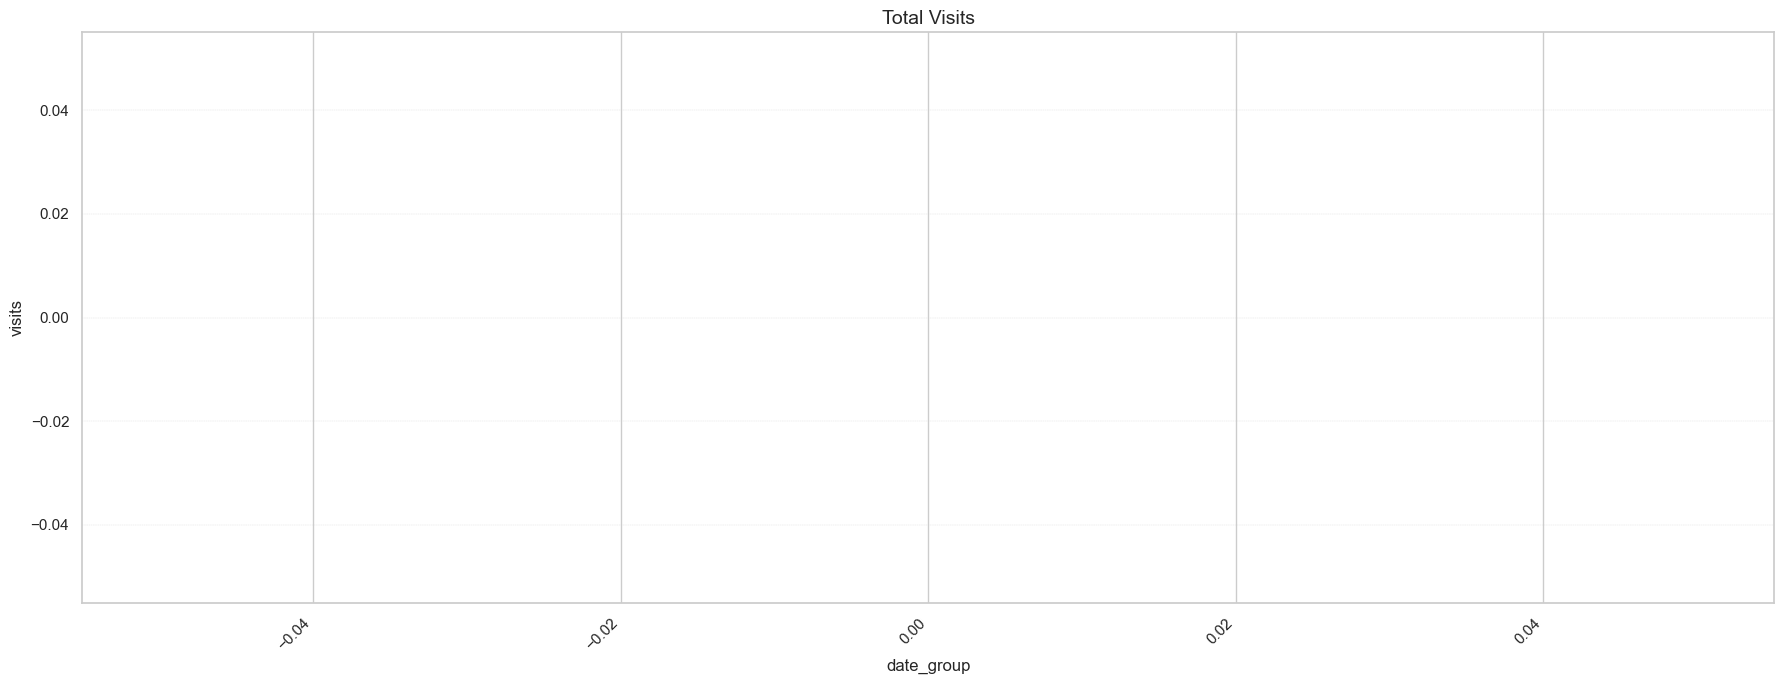

In [18]:
daily_visits = (result_df
                .groupby('date_group', as_index=False)['visits']
                .sum()
                .sort_values('date_group'))
fig, ax = plt.subplots(figsize=(18, 7))
bars = ax.bar(daily_visits['date_group'],
              daily_visits['visits'])

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=8)

ax.set_title('Total Visits', fontsize=14)
ax.set_xlabel('date_group')
ax.set_ylabel('visits')
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', linewidth=0.3, alpha=0.7)

plt.tight_layout()
plt.savefig('./charts/total_visits.png')

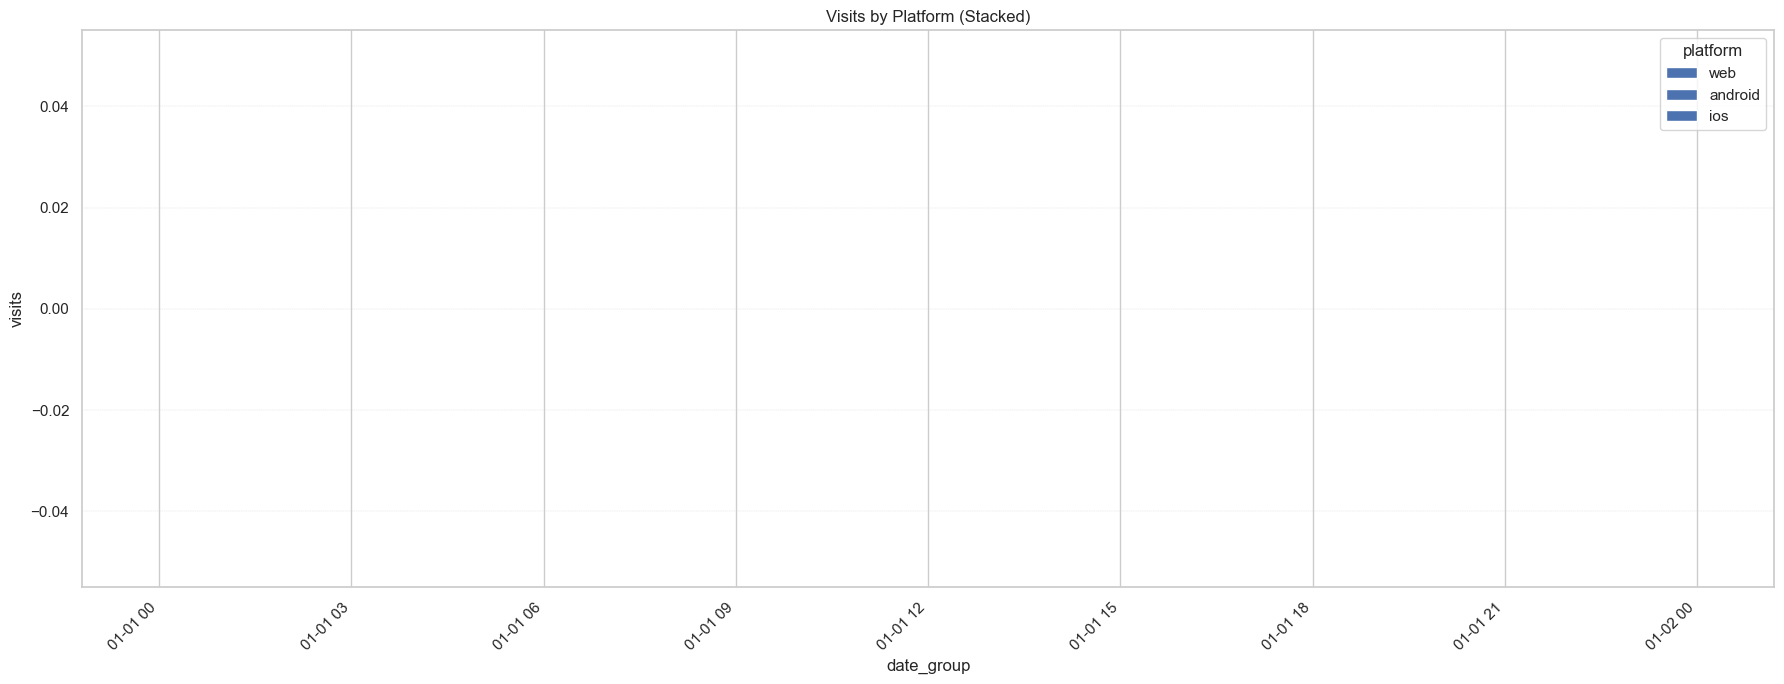

In [19]:
conversion_df['date_group'] = pd.to_datetime(conversion_df['date_group'])

pivot = (conversion_df
         .pivot_table(index='date_group',
                      columns='platform',
                      values='visits',
                      aggfunc='sum')
         .fillna(0)
         .sort_index())
pivot = pivot.reindex(columns=['web', 'android', 'ios'])

fig, ax = plt.subplots(figsize=(18, 7))

bottom = np.zeros(len(pivot))
colors = {'web':   '#2ca02c',
          'android': '#1f77b4',
          'ios':    '#ff7f0e'}

for platform in pivot.columns:
    ax.bar(pivot.index,
           pivot[platform],
           bottom=bottom,
           label=platform,
           color=colors.get(platform))
    bottom += pivot[platform].values

plt.xticks(rotation=45, ha='right')

ax.set_title('Visits by Platform (Stacked)')
ax.set_xlabel('date_group')
ax.set_ylabel('visits')
ax.legend(title='platform')
ax.grid(axis='y', linestyle='--', linewidth=0.3, alpha=0.7)
plt.savefig('./charts/Visits_by_platform.png')
plt.tight_layout()
plt.show()

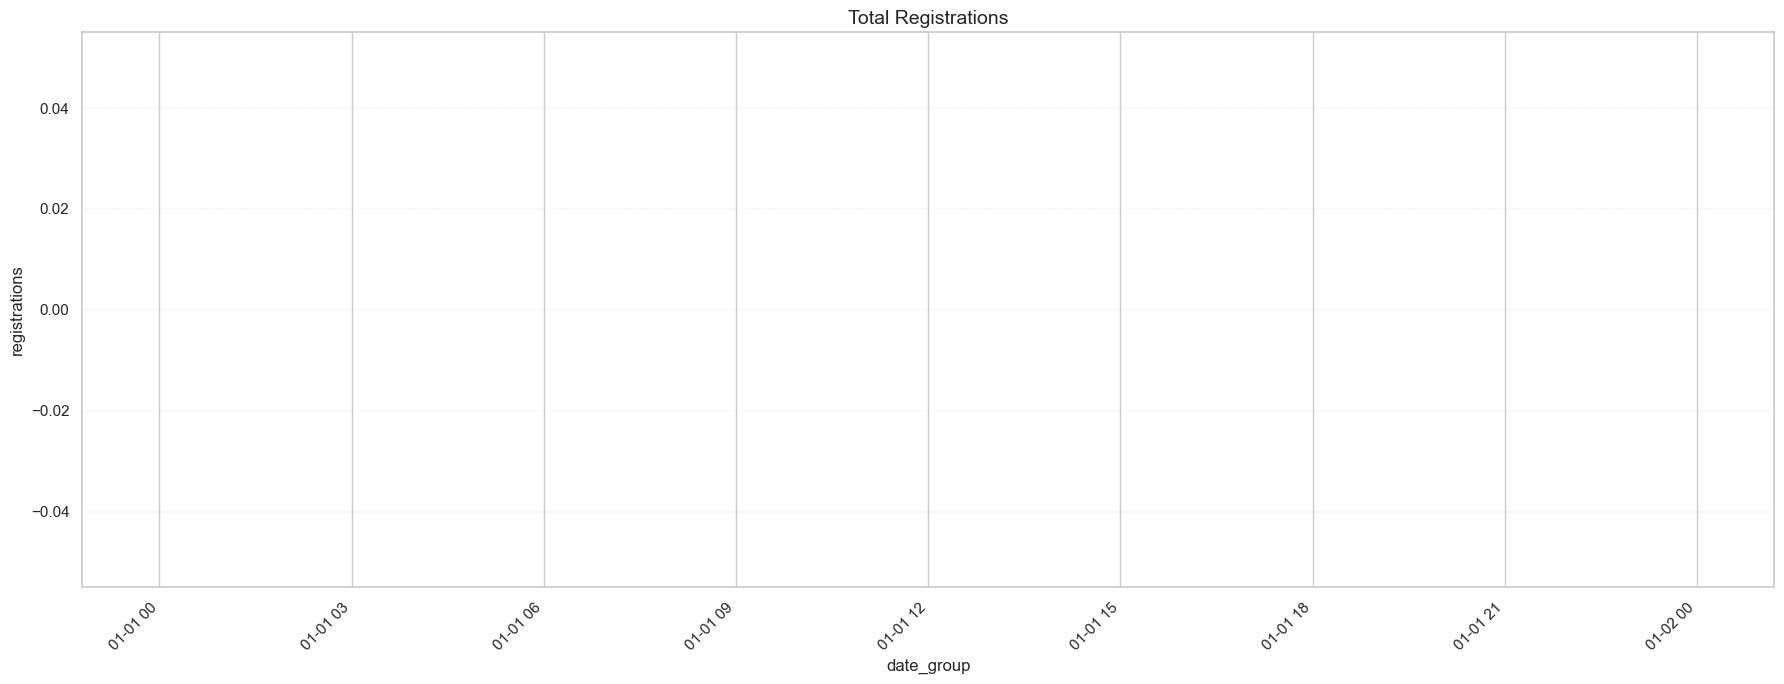

In [20]:
result_df['date_group'] = pd.to_datetime(result_df['date_group'])
daily_regs = (
    result_df
    .groupby('date_group', as_index=False)['registrations']
    .sum()
    .sort_values('date_group')
)
fig, ax = plt.subplots(figsize=(18, 7))
bars = ax.bar(daily_regs['date_group'],
              daily_regs['registrations'],
              color='#7fb8d6')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=8, color='black')

ax.set_title('Total Registrations', fontsize=14)
ax.set_xlabel('date_group')
ax.set_ylabel('registrations')

plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', linewidth=0.3, alpha=0.7)
plt.savefig('./charts/total_registrations.png')
plt.tight_layout()
plt.show()

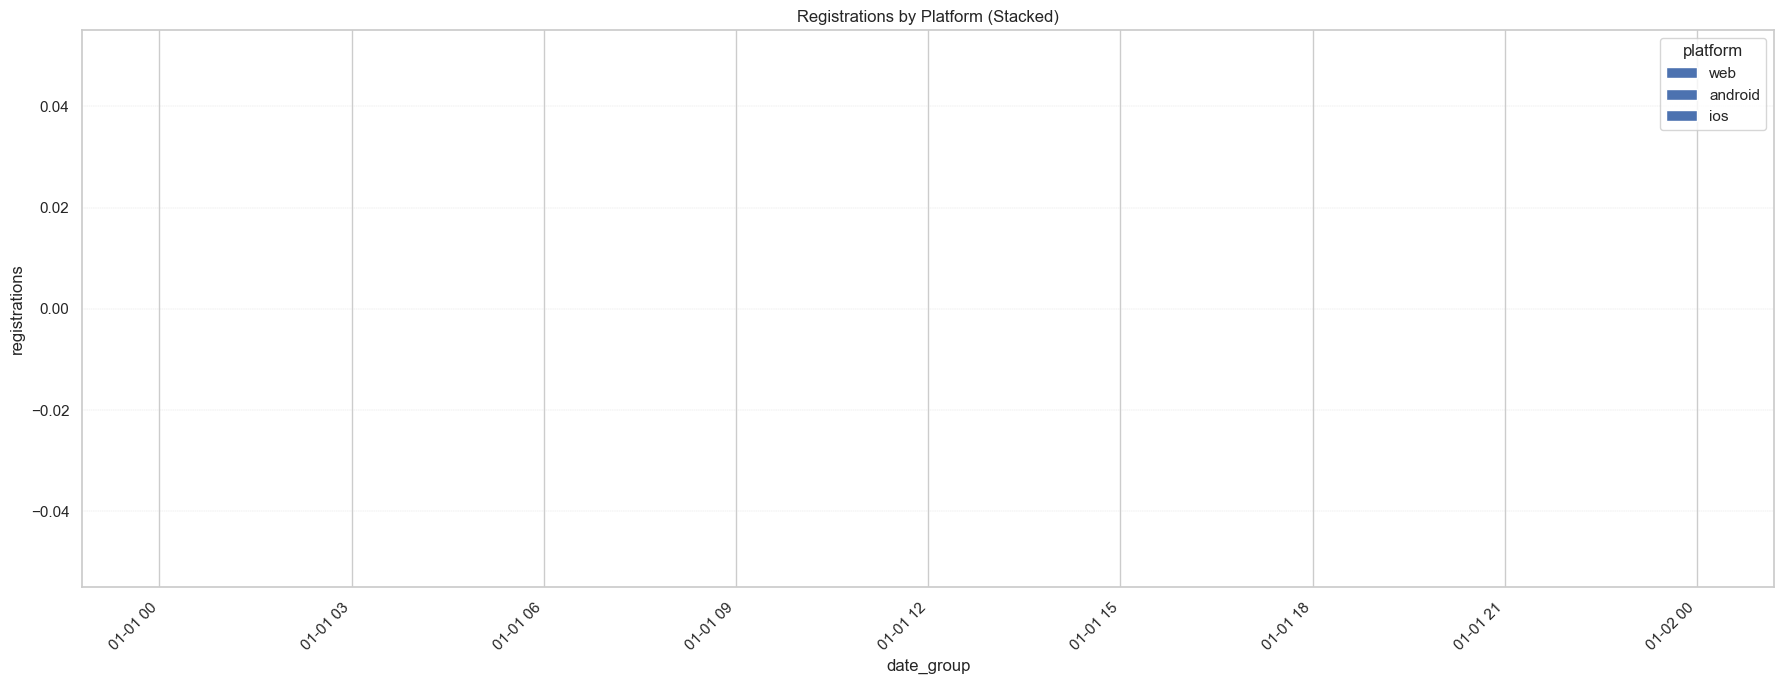

In [21]:
conversion_df['date_group'] = pd.to_datetime(conversion_df['date_group'])
pivot_regs = (conversion_df
              .pivot_table(index='date_group',
                           columns='platform',
                           values='registrations',
                           aggfunc='sum')
              .fillna(0)
              .sort_index())

pivot_regs = pivot_regs.reindex(columns=['web', 'android', 'ios'])

fig, ax = plt.subplots(figsize=(18, 7))

bottom = np.zeros(len(pivot_regs))
palette = {'web':     '#2ca02c',
           'android': '#1f77b4',
           'ios':     '#ff7f0e'}

for platform in pivot_regs.columns:
    ax.bar(pivot_regs.index,
           pivot_regs[platform],
           bottom=bottom,
           label=platform,
           color=palette.get(platform))
    bottom += pivot_regs[platform].values

plt.xticks(rotation=45, ha='right')

ax.set_title('Registrations by Platform (Stacked)')
ax.set_xlabel('date_group')
ax.set_ylabel('registrations')
ax.legend(title='platform')
ax.grid(axis='y', linestyle='--', linewidth=0.3, alpha=0.7)
plt.savefig('./charts/regs_by_platform.png')
plt.tight_layout()
plt.show()

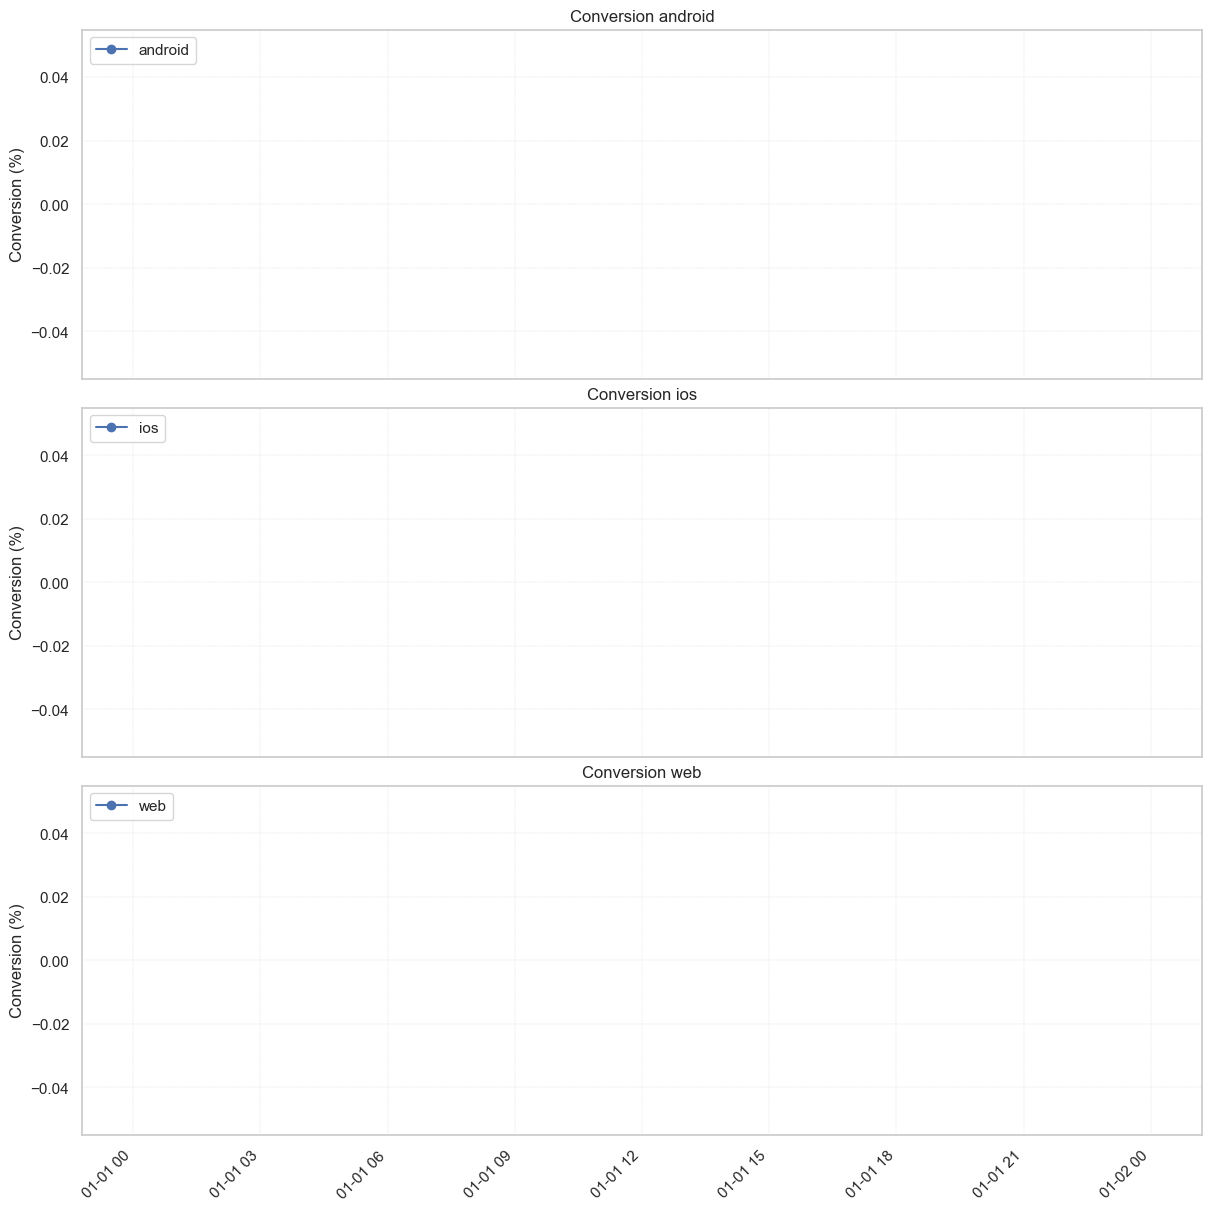

In [22]:
conversion_df['date_group'] = pd.to_datetime(conversion_df['date_group'])
conv_daily = (conversion_df
              .groupby(['date_group', 'platform'], as_index=False)['conversion']
              .mean())
platform_order = ['android', 'ios', 'web']

fig, axes = plt.subplots(nrows=3,
                         ncols=1,
                         figsize=(12, 12),
                         sharex=True,
                         constrained_layout=True)

for ax, plat in zip(axes, platform_order):
    data = conv_daily[conv_daily['platform'] == plat].sort_values('date_group')

    ax.plot(data['date_group'],
            data['conversion'],
            marker='o',
            linestyle='-',
            label=plat)

    for x, y in zip(data['date_group'], data['conversion']):
        ax.annotate(f'{y:.0f}%', (x, y),
                    textcoords='offset points',
                    xytext=(0, 6),
                    ha='center',
                    fontsize=8)

    ax.set_title(f'Conversion {plat}')
    ax.set_ylabel('Conversion (%)')
    ax.grid(True, linestyle='--', linewidth=0.3, alpha=0.7)
    ax.legend(loc='upper left')

plt.setp(axes[-1].get_xticklabels(), rotation=45, ha='right')
plt.savefig('./charts/conversions_on_platform.png')
plt.show()

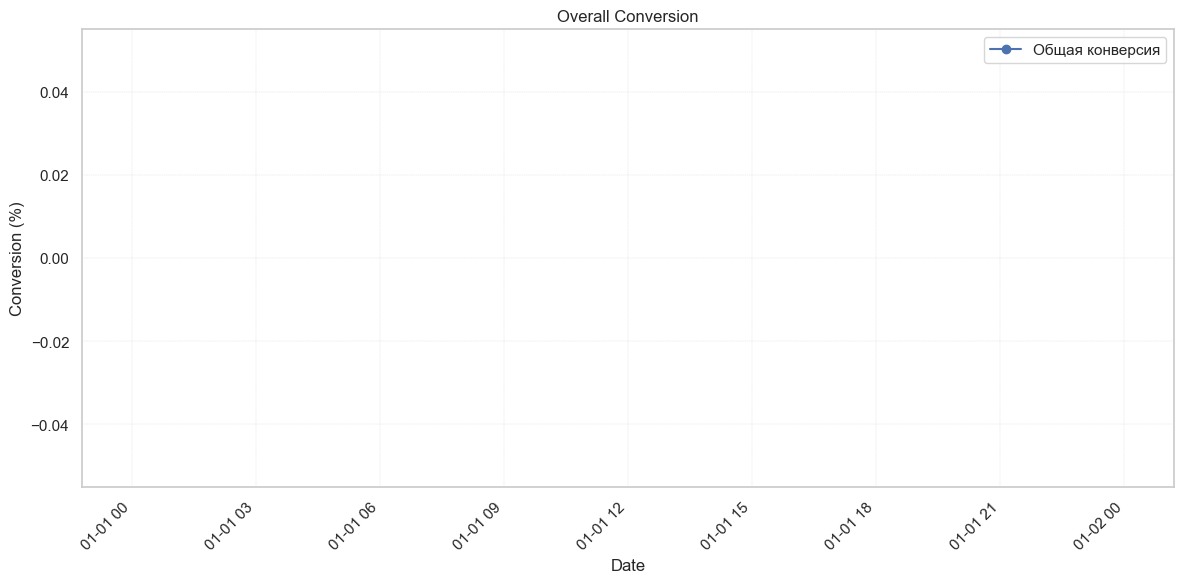

In [23]:
result_df['date_group'] = pd.to_datetime(result_df['date_group'])
daily_totals = (result_df
                .groupby('date_group', as_index=False)
                .agg({'visits': 'sum', 'registrations': 'sum'})
                .sort_values('date_group'))
daily_totals['conversion'] = (daily_totals['registrations']
                              / daily_totals['visits'] * 100)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(daily_totals['date_group'],
        daily_totals['conversion'],
        marker='o',
        linestyle='-',
        label='Общая конверсия')

for x, y in zip(daily_totals['date_group'], daily_totals['conversion']):
    ax.annotate(f'{y:.0f}%', (x, y),
                textcoords='offset points',
                xytext=(0, 6),
                ha='center',
                fontsize=8)

ax.set_title('Overall Conversion')
ax.set_xlabel('Date')
ax.set_ylabel('Conversion (%)')
ax.legend()

plt.xticks(rotation=45, ha='right')

ax.grid(True, linestyle='--', linewidth=0.3, alpha=0.7)
plt.tight_layout()
plt.savefig('./charts/overall_conversion.png')
plt.show()

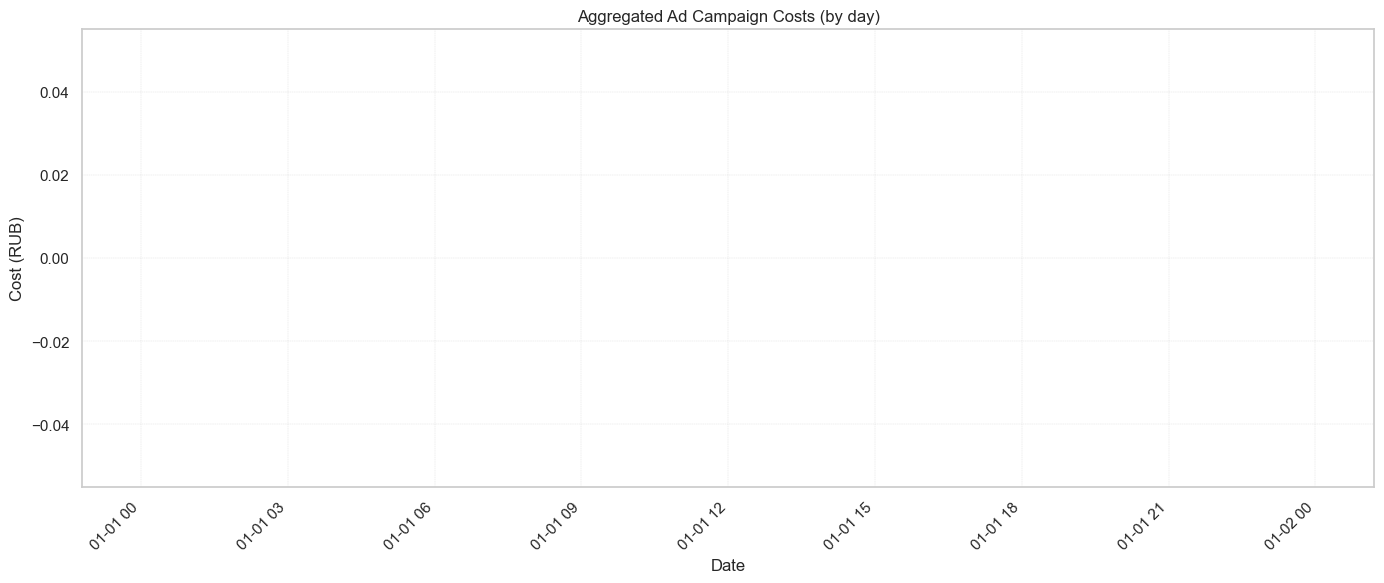

In [24]:
result_df['date_group'] = pd.to_datetime(result_df['date_group'])
daily_costs = (result_df
               .groupby('date_group', as_index=False)['cost']
               .sum()
               .sort_values('date_group'))

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(daily_costs['date_group'],
        daily_costs['cost'],
        marker='o',
        linestyle='-')

for x, y in zip(daily_costs['date_group'], daily_costs['cost']):
    ax.annotate(f'{int(y)} RUB', (x, y),
                textcoords='offset points',
                xytext=(0, 6),
                ha='center',
                fontsize=8)

ax.set_title('Aggregated Ad Campaign Costs (by day)')
ax.set_xlabel('Date')
ax.set_ylabel('Cost (RUB)')
plt.xticks(rotation=45, ha='right')

ax.grid(True, linestyle='--', linewidth=0.3, alpha=0.7)
plt.tight_layout()
plt.savefig('./charts/agg_ad_cam_costs.png')
plt.show()

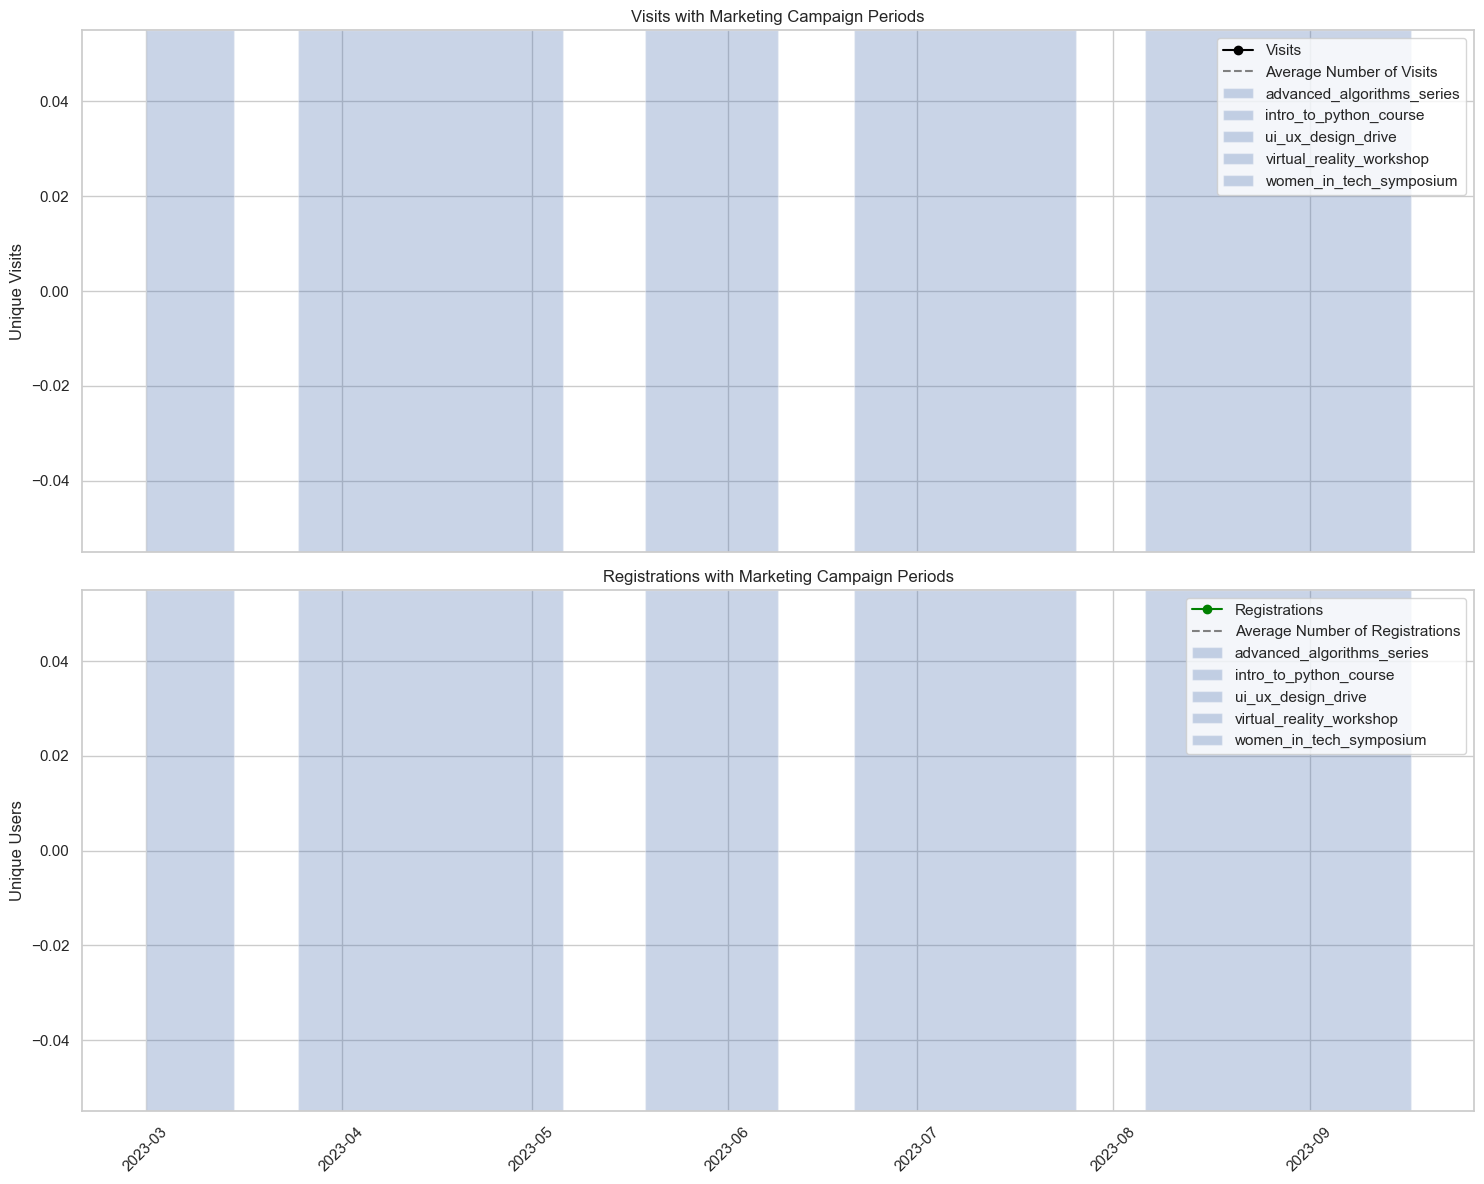

In [25]:
daily = result_df.groupby('date_group').agg({
    'visits': 'sum',
    'registrations': 'sum'
}).reset_index()

campaigns = ads_df.groupby('utm_campaign').agg(
    start=('date_group', 'min'),
    end=('date_group', 'max')
).reset_index()

fig, ax = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# === ВИЗИТЫ ===
ax[0].plot(daily['date_group'], daily['visits'], '-o', color='black', label='Visits')
ax[0].axhline(daily['visits'].mean(), color='gray', linestyle='--', label='Average Number of Visits')

# Рекламные фоны
for _, row in campaigns.iterrows():
    ax[0].axvspan(row['start'], row['end'], alpha=0.3, label=row['utm_campaign'])

ax[0].set_ylabel('Unique Visits')
ax[0].legend()
ax[0].set_title('Visits with Marketing Campaign Periods')

# === РЕГИСТРАЦИИ ===
ax[1].plot(daily['date_group'], daily['registrations'], '-o', color='green', label='Registrations')
ax[1].axhline(daily['registrations'].mean(), color='gray', linestyle='--', label='Average Number of Registrations')

for _, row in campaigns.iterrows():
    ax[1].axvspan(row['start'], row['end'], alpha=0.3, label=row['utm_campaign'])

ax[1].set_ylabel('Unique Users')
ax[1].legend()
ax[1].set_title('Registrations with Marketing Campaign Periods')

plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('./charts/visits_and_regs.png')
plt.show()